# V.1 Exploring the green reds

a) function to plot a scatterplot matrix of given data

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    red_wine = pd.read_csv(wine_data, sep=';')
    numvars, numdata = red_wine.shape
    fig = plt.figure()
    fig, axes = plt.subplots(numdata, numdata, figsize=(100, 100))
    for i in range(numdata):
        for j in range(numdata):
            if (i == j):
                axes[i, j].text(0.5, 0.5, red_wine.columns[i], fontsize=40, ha='center')
            else:
                colors = ['blue' if k >= good_threshold else 'red' for k in red_wine['quality']]
                size = [20 if k >= good_threshold else 20 if k <= bad_threshold else 0 for k in red_wine['quality']]
                axes[i, j].scatter(red_wine[red_wine.columns[i]], red_wine[red_wine.columns[j]], c=colors, s=size)
    plt.tight_layout()
    if (save_plot == True):
        plt.savefig('figure.png')
    else:
        fig

In [3]:
plot_scatter_matrix('winequality-red.csv', 7, 4, )

<Figure size 432x288 with 0 Axes>

b) which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

A: Alcohol will be most useful data to distinguish high quality versus low quality wines. When looking at each data vs quality graph, alcohol is the only data that has a correlation with the quality. Most wine with quality 8 has alcohol percentage that is between 10 and 14 while wine with quality 3 has alcohol percentage between 8 and 11. Also, level of sulphateis also correlated to quality, but just not as strong as alcohol.

# V.2 Learning to perceptron
a) Implement a perceptron that:
    1) Has randomly initialized weights and bias
    2) Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
    3) Utilizes the heaviside step activation function (discrete version)
    
b) Implelment a function to train perceptron:
    1) Specify number of training epochs (n_iter)
    2) If n_iter == 0, run until it makes no errors
    3) Specify learning rate (eta)
    4) Return list of python tuples containing:
        [(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), ...]

In [4]:
import random

def heaviside_step_function(x, good):
    ret = [0] * len(x)
    j = 0
    for i in x:
        if (i >= good and i != 0):
            ret[j] = 1
        else:
            ret[j] = -1
        j += 1
    return (ret)

def infinity():
    i = 0
    while True:
        yield i
        i += 1

def dot_product(X, w):
    ret = 0
    for i in range(len(w)):
        ret += X[i] * w[i]
    return (ret)

In [5]:
class Perceptron():
    def __init__(self, thresholds=0.0, eta=0.01, n_iter=10):
        self.thresholds = thresholds
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        # randomly initialized weights(w[1:]) and bias(w[0])
        random.seed(3003)
        self.w = [random.random()] * (1 + X.shape[1])
        ret = []
        
        # Rosenblatt perceptron learning rule (adjusting slope of line)
        for i in infinity() if self.n_iter == 0 else range(self.n_iter):
            tmp_errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w[1:] += update * xi
                self.w[0] += update
                tmp_errors += int(update != 0.0)
            tup = (i, tmp_errors, self.w[1:], self.w[0])
            ret.append(tup)
            if (tmp_errors == 0 and self.n_iter == 0):
                break
        
        return (ret)
    
    def net_input(self, X):
        return (dot_product(X, self.w[1:]) + self.w[0])
    
    def predict(self, X):
        return (1 if self.net_input(X) > self.thresholds else -1)

c) A function that will take the output of perceptron training function and red wine data and generatet wo plots in one figure
    1) First plot: plot the number of errors that perceptron made as a function of epoch
    2) Second plot: plot the decision boundary of perceptron and show 'good' and 'bad' wine data points on the final training epoch. Shade 'good' and 'bad' areas.
    3) If a negative epoch is given, plots shows the last epoch

In [6]:
def find_min_max(max_, data):
    ret = data[0]
    if max_ == 0:
        for val in data:
            if val < ret:
                ret = val
    else:
        for val in data:
            if val > ret:
                ret = val
    return (ret)

def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    errors = []
    for t in performance:
        errors.append(t[1])
    if (epoch < 0):
        tup = performance[len(performance) - 1]
    else:
        tup = performance[epoch]
        
    y_min = find_min_max(0, wine_data[wine_data.columns[0]].values)
    y_max = find_min_max(1, wine_data[wine_data.columns[0]].values)    
    x_min = find_min_max(0, wine_data[wine_data.columns[1]].values)
    x_max = find_min_max(1, wine_data[wine_data.columns[1]].values)
    
    wine_data0 = wine_data[wine_data['quality'] < good_thresh]
    wine_data1 = wine_data[wine_data['quality'] >= good_thresh]
    
    y = [0] * 11
    x = [0] * 11
    
    slope = -(tup[3]/tup[2][0])/(tup[3]/tup[2][1])
    intercept = -tup[3]/tup[2][0]
    k = 0
    for i in range(11):
        x[i] = k + x_min
        y[i] = slope * x[i] + intercept
        k += (x_max - x_min) / 10

    fg = plt.figure(figsize=(20, 5))
    ax1 = fg.add_subplot(121)
    ax2 = fg.add_subplot(122)
    ax1.plot(range(0, performance[len(performance) - 1][0]), errors[1:])
    ax1.set_title("Errors as a function of epoch")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("classification errors")
    
    ax2.plot(x, y, label="Decision Boundary")
    ax2.axis([x_min, x_max, y_min, y_max])
    ax2.fill_between(x, y, y_min - 2, where=y>y_min - 2, facecolor='blue', alpha=.2)
    ax2.fill_between(x, y, y_max + 2, where=y<y_max + 2, facecolor='red', alpha=.2)
    ax2.scatter(wine_data0[wine_data0.columns[1]], wine_data0[wine_data0.columns[0]], c='red', label='bad wines(<{0} score)'.format(bad_thresh + 1), s=20)
    ax2.scatter(wine_data1[wine_data1.columns[1]], wine_data1[wine_data1.columns[0]], c='blue', label='good wines(>{0} score)'.format(good_thresh -1), s=20)
    ax2.set_title("Decision boundary on epoch: {0}".format(tup[0]))
    ax2.set_xlabel(wine_data.columns[1])
    ax2.set_ylabel(wine_data.columns[0])
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    if (save_plot == True):
        plt.savefig('plot_performance.png')
    else:
        plt.show()

d) Using plot_performance function to plot and verify that perceptron learn more efficiently when data is modified

    Feature Scaling

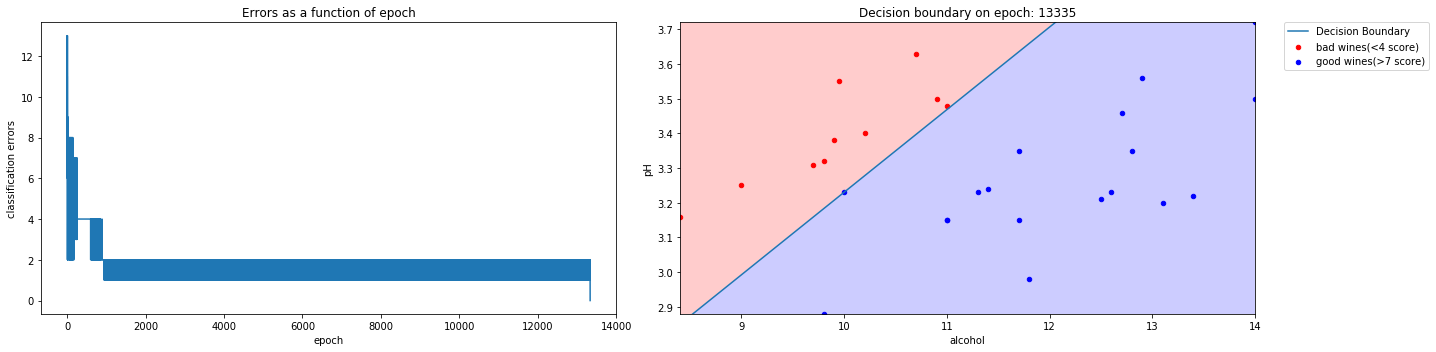

In [7]:
def before():
    df = pd.read_csv('winequality-red.csv', sep=';')
    df = df[(df.quality >= 8) | (df.quality <= 3)]
    y = df['quality'].values
    y = heaviside_step_function(y, 8)
    X = df[['pH', 'alcohol']].values

    # made as class to make it easier to modify, eta: learning rate; n_iter: training epochs
    ppn1 = Perceptron(eta=0.1, n_iter = 0)
    ret = ppn1.fit(X, y)
    plot_performance(ret, df[['pH', 'alcohol', 'quality']], 8, 3, )
    
before()

In [7]:
def mean(numbers):
    return (sum(numbers) / len(numbers))

def after():
    df = pd.read_csv('winequality-red.csv', sep=';')
    df = df[(df.quality >= 8) | (df.quality <= 3)]
    y = df['quality'].values
    y = heaviside_step_function(y, 8)
    X = df[['pH', 'alcohol']].values

    X0_min = find_min_max(0, df['pH'].values)
    X1_min = find_min_max(0, df['alcohol'].values)
    X0_max = find_min_max(1, df['pH'].values)
    X1_max = find_min_max(1, df['alcohol'].values)
    X0_mean = mean(df['pH'].values)
    X1_mean = mean(df['alcohol'].values)

    tmp = df[['pH', 'alcohol', 'quality']]
    
    for i in range(len(X)):
        X[i][0] = (X[i][0] - X0_mean) / (X0_max - X0_min)
        X[i][1] = (X[i][1] - X1_mean) / (X1_max - X1_min)
        tmp['pH'].values[i] = X[i][0]
        tmp['alcohol'].values[i] = X[i][1]

    # made as class to make it easier to modify, eta: learning rate; n_iter: training epochs
    ppn1 = Perceptron(n_iter = 0)
    ret = ppn1.fit(X, y)
    
    plot_performance(ret, tmp[['pH', 'alcohol', 'quality']], 8, 3, )

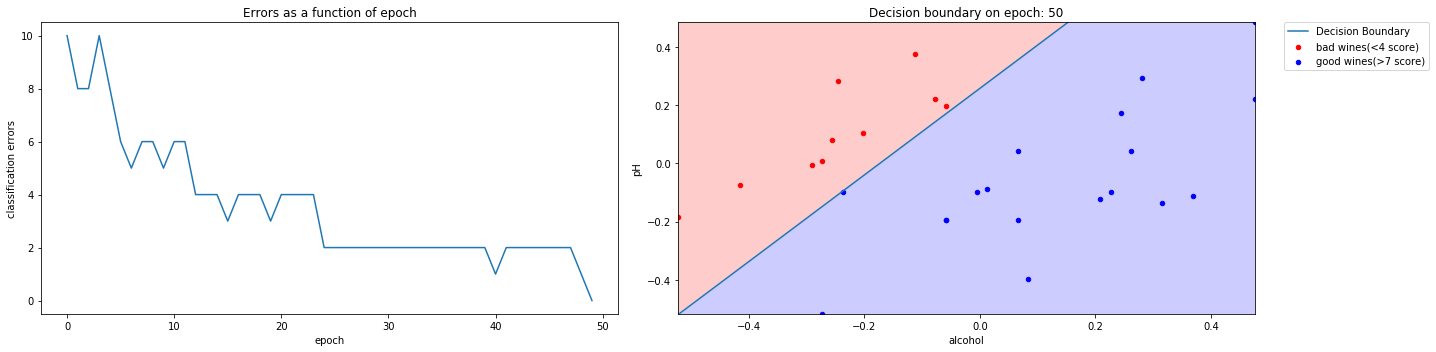

In [9]:
after()

# V.3 My fair ADALINE

Use perceptron to distinguish between wines with a score of 4 an lower, and wines with a score of 7 and higher

a) Trying to let the perceptron train until it can find the best decision boundary will fail. Why it won't work?
    Perceptron compares value from activation fucntion return 1 or -1 depend on threshold and return value of net input function to retrun value of actual value (y) based on threshold and update the weight. While perceptron uses a threshold as a reference of right or worng, it is less powerful than Adaline. In contrast adaline uses continuous predicted values to learn the model coefficients and tells how much it is right or worng.
    
b) Implement an ADALINE that:
    1) Has randomly initialized weight and bias
    2) Uses a linear activation function and some kind of quantizer
    3) Uses the Widrow-Hoff learning rule
    
c) Train your ADALINE:
    1) Take red wine data
    2) Specify number of training epochs
    3) epoch == 0? train until converges on a good set of weights
    4) Specify learning rate
    5) option to perform either online learning or batch learning

In [8]:
def add_to_array(X, w):
    ret = []
    for j in range(len(X)):
        ret += [X[j] + w]
    return (ret)

def dot_adaline(X, w):
    ret = []
    for j in range(X.shape[0]):
        ret += [((X[j][0] * w[0]) + (X[j][1] * w[1]))]
    return (ret)

def list_minus_list(lst1, lst2):
    ret = []
    for i in range(len(lst1)):
        ret += [lst1[i] - lst2[i]]
    return (ret)

def transposed_matrix(lst):
    ret = []
    ret.append([x[0] for x in lst])
    ret.append([x[1] for x in lst])
    return (ret)

def dot_product_adaline(lst1, lst2):
    ret1 = 0
    ret2 = 0
    for i in range(len(lst2)):
        ret1 += lst1[0][i] * lst2[i]
        ret2 += lst1[1][i] * lst2[i]
    return ([ret1, ret2])

def mult_lst(lst, no):
    ret = []
    for i in lst:
        ret += [i * no]
    return (ret)

def add_lst(lst1, lst2):
    ret1 = 0
    ret2 = 0
    return ([lst1[0] + lst2[0], lst1[1] + lst2[1]])

class Adaline():
    def __init__(self, eta=0.01, n_iter=100, batch=False, batch_size=10):
        self.eta = eta
        self.n_iter = n_iter
        self.batch = batch
        self.batch_size = batch_size
    
    def fit(self, X, y):
        random.seed(3003)
        self.w = [random.random()] * (1 + X.shape[1])
        ret = []
        
        if self.batch:
            combine = list(zip(X, y))
            random.shuffle(combine)
            X[:], y[:] = zip(*combine)
            X = X[:self.batch_size]
            y = y[:self.batch_size]

        for i in infinity() if self.n_iter == 0 else range(self.n_iter):
            output = self.net_input(X)
            errors = list_minus_list(y, output)
            self.w[1:] = add_lst(self.w[1:], mult_lst(dot_product_adaline(transposed_matrix(X), errors), self.eta))
            self.w[0] += self.eta * sum(errors)
            c = sum(i**2 for i in errors) / 2
            tup = (i, sum(errors), self.w[1:], self.w[0], c)
            ret.append(tup)
            if (i > 2 and abs(ret[i - 1][4]) < abs(ret[i][4]) and self.n_iter == 0):
                break
        return (ret)
    
    def net_input(self, X):
        return (add_to_array(dot_adaline(X, self.w[1:]), self.w[0]))
    
    def predict(self, X):
        return (1 if self.net_input(X) >= 0 else -1)

d) What is the good learning rate for ADALINE? plot number of classification errors vs epoch and decision boundary. What setting give the smallest number of classification errors?

for the case of red wine data, good learning rate for ADALINE was around 0.0001. If it was too large, it converges to infinity. However, when smaller value was given, it required more iteration (or epoch) to get a best fitted line. Also, cost drops fastest at 0.0001 for df.quality >= 8 and df.quality <= 3

In [9]:
def plot_cost(cost, epoch):
    plt.plot(epoch, cost)
    plt.title("Cost vs Epoch")
    plt.xlabel("epoch")
    plt.ylabel("Cost")
    plt.show()

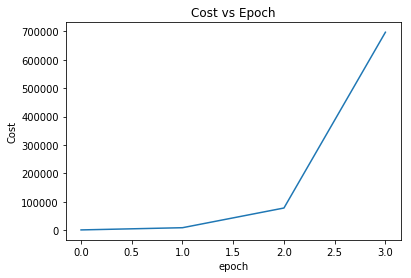

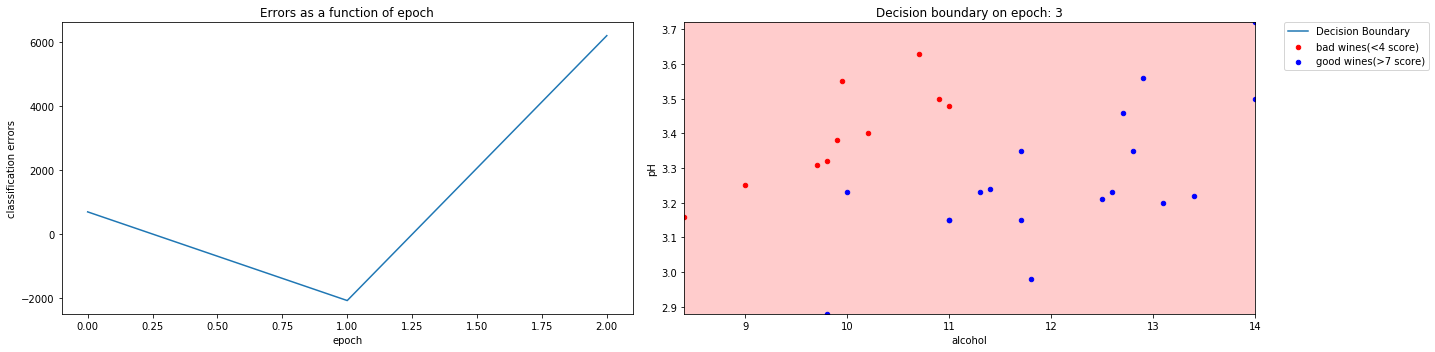

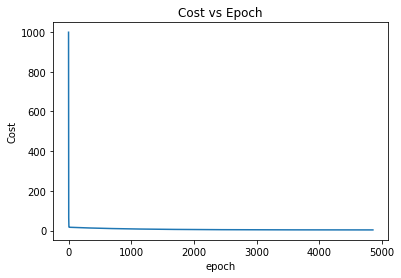

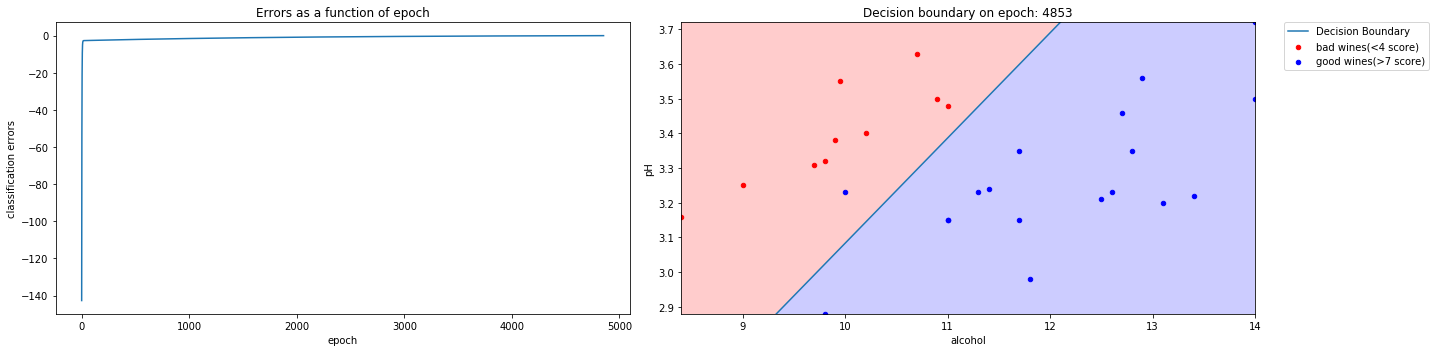

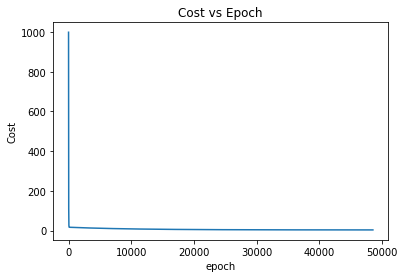

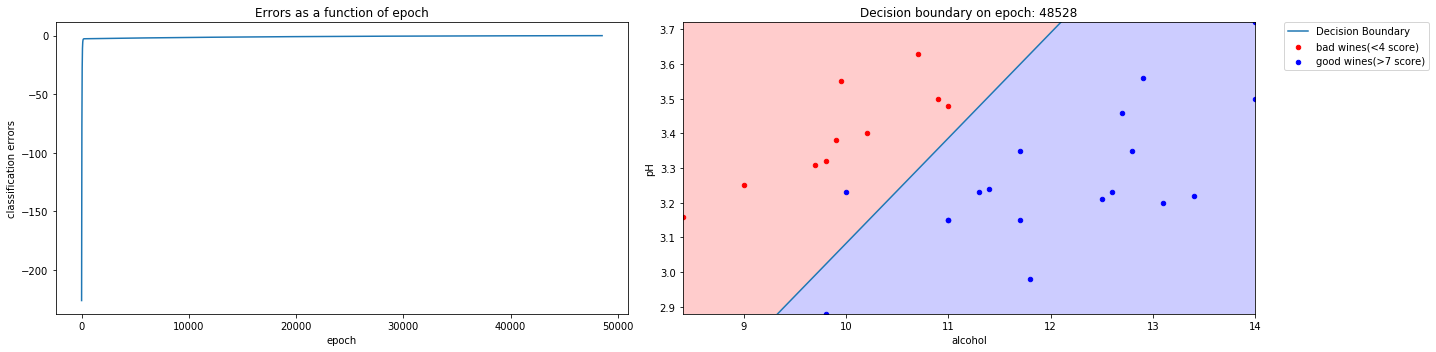

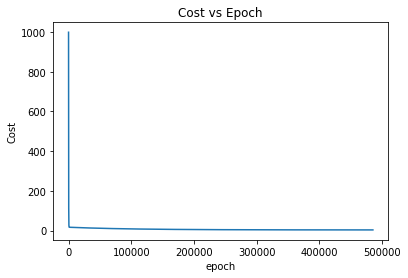

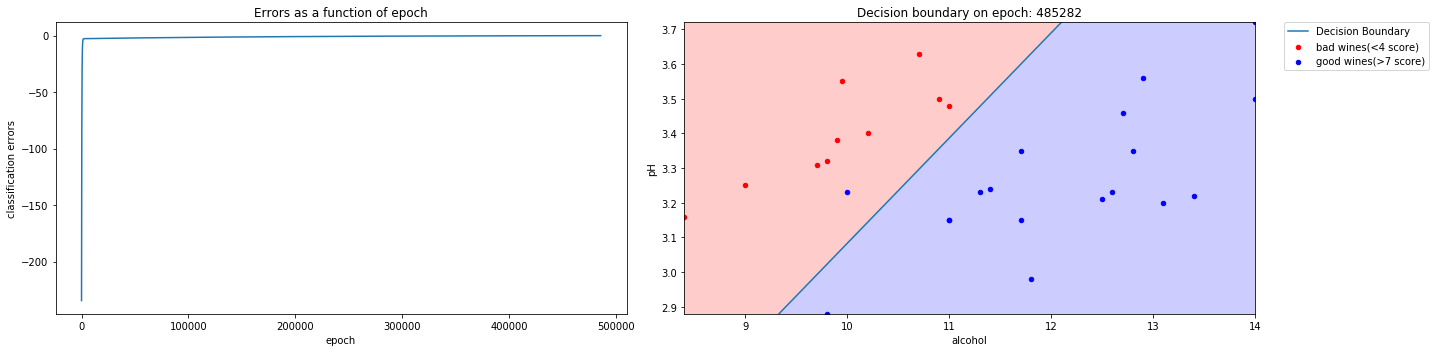

In [17]:
def before2(eta_tmp=0.0001, iteration=100):
    df = pd.read_csv('winequality-red.csv', sep=';')
    df = df[(df.quality >= 8) | (df.quality <= 3)]
    y = df['quality'].values
    y = heaviside_step_function(y, 8)
    X = df[['pH', 'alcohol']].values

    # made as class to make it easier to modify, eta: learning rate; n_iter: training epochs
    ppn1 = Adaline(eta = eta_tmp, n_iter = iteration)
    ret = ppn1.fit(X, y)
    plot_cost([x[4] for x in ret], [x[0] for x in ret])
    plot_performance(ret, df[['pH', 'alcohol', 'quality']], 8, 3, )

before2(eta_tmp=0.001, iteration=0)
before2(eta_tmp=0.0001, iteration=0)
before2(eta_tmp=0.00001, iteration=0)
before2(eta_tmp=0.000001, iteration=0)

# V.4 Advanced wine sampling and resampling

Too much training can lead ADALINE to overfitting, which can lead to poor performance when the ADALINE encounters new data it has never seen before. Using a validation set and/or cross-validation methodologies to reduces (but not completely eliminate) the possibility of overfitting.

a) Function that uses the holdout method to partition the red wine data into a training and a validation set. Function should take a parameter to adjust the proportion of training to validation data. Return a tuple containing:

(training_pandas_dataframe, validation_pandas_dataframe)

In [10]:
# holdout method: All data is randomly divided into same equal size data sets:
# 1) training set: Data set helps in the prediction of the model
# 2) validation set: Data set used to assess the performance of model built during the training

def holdout_method(data):
    validation_num = int(data.shape[0] * 0.5)
    data_random = data.sample(frac=1)
    tup = (data_random[:validation_num], data_random[validation_num:])
    return (tup)

b) Function that generates a k-fold cross-validation dataset from the data. 

In [11]:
def k_fold_cross_validation(data, k = 5):
    num_data = int(data.shape[0] * (1 / k))
    data_random = data.sample(frac=1)
    ret = []
    for i in range(0, k):
        validation_data = data_random[(num_data * i):(num_data * (i + 1))]
        if (i != 0):
            front = data_random[:num_data * i]
            end = data_random[num_data * (i + 1):]
            training_data = front.append(end)
        else:
            training_data = data_random[num_data * (i + 1):]
        tup = (training_data, validation_data)
        ret.append(tup)       
    return (ret)

c) Write a function that will train and assess the ADALINE on each training and cross-validation fold produced by k-fold function. What effects does changing learning rate and number of training epochs have on the ADALINE when evaluated via k-fold cross-validation?

As number of epoch increases, validation error got bigger due to overfitting.
changing learning rate does impact ADALINE a lot, while too small will send cost to infinite, and too large will take longer time and has bigger cost.

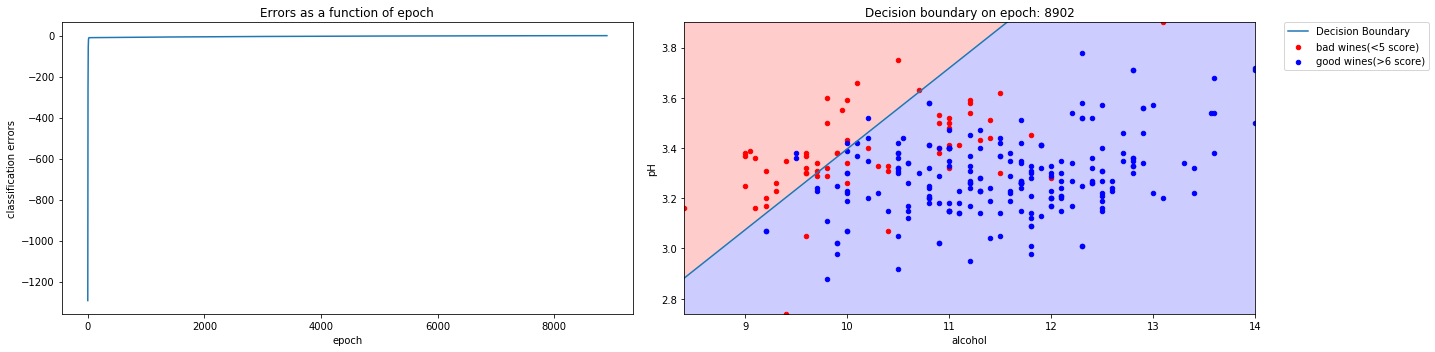

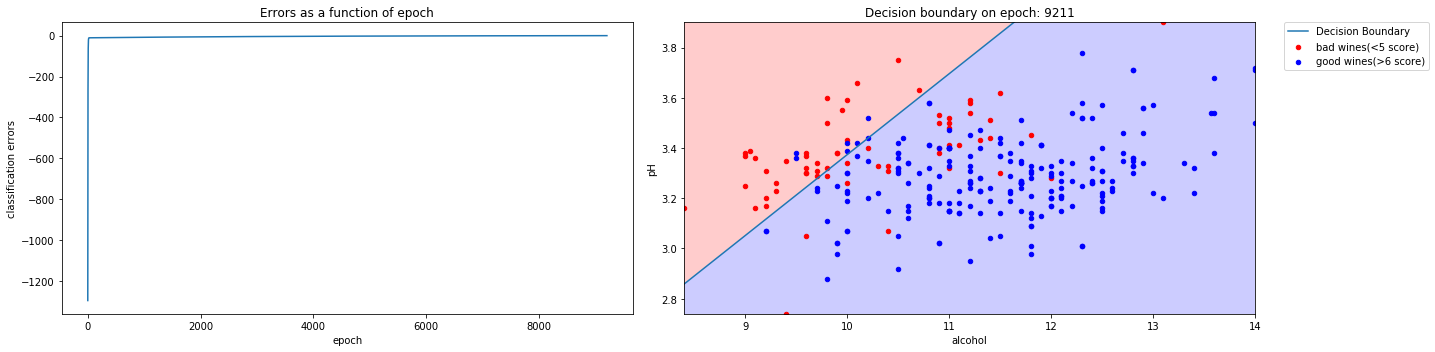

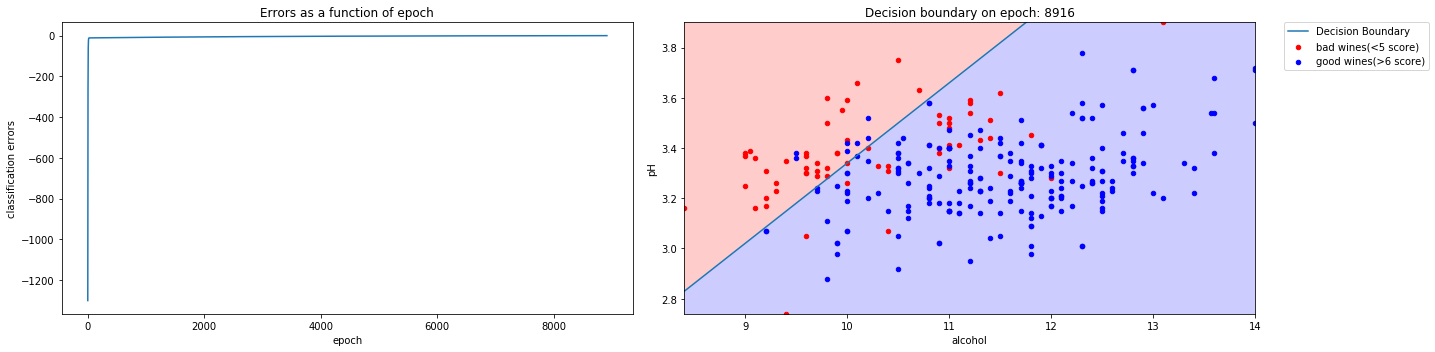

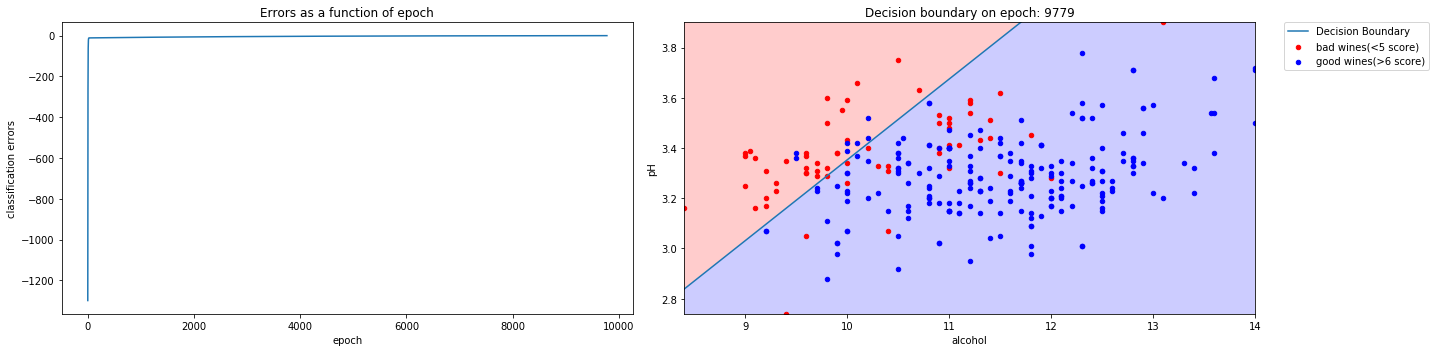

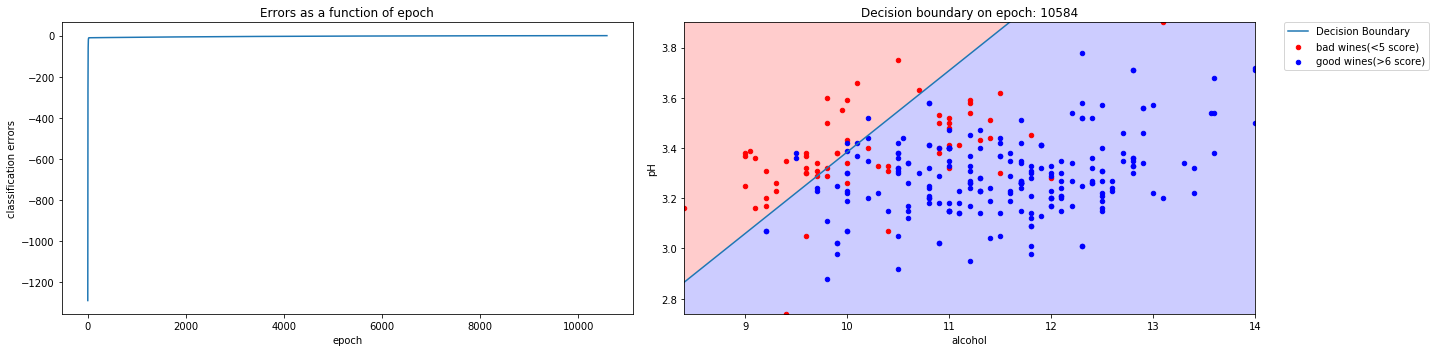

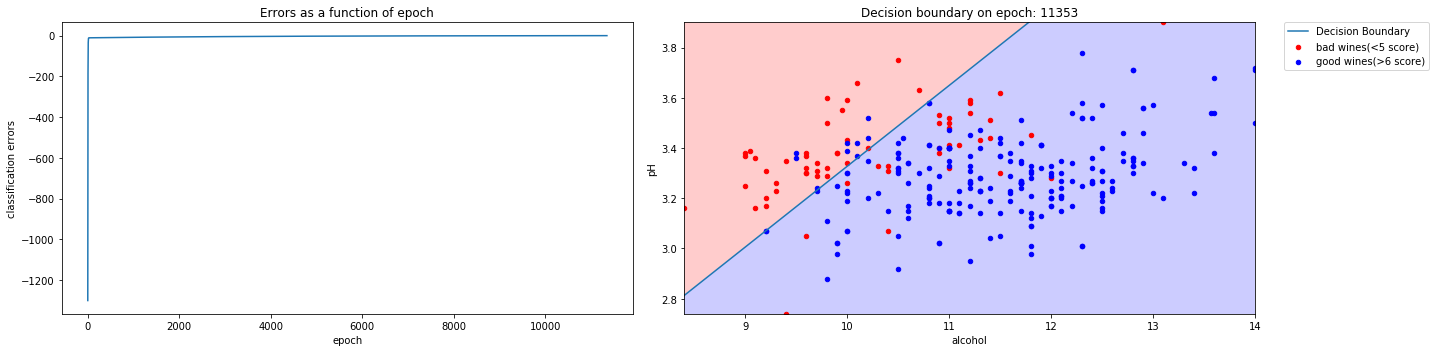

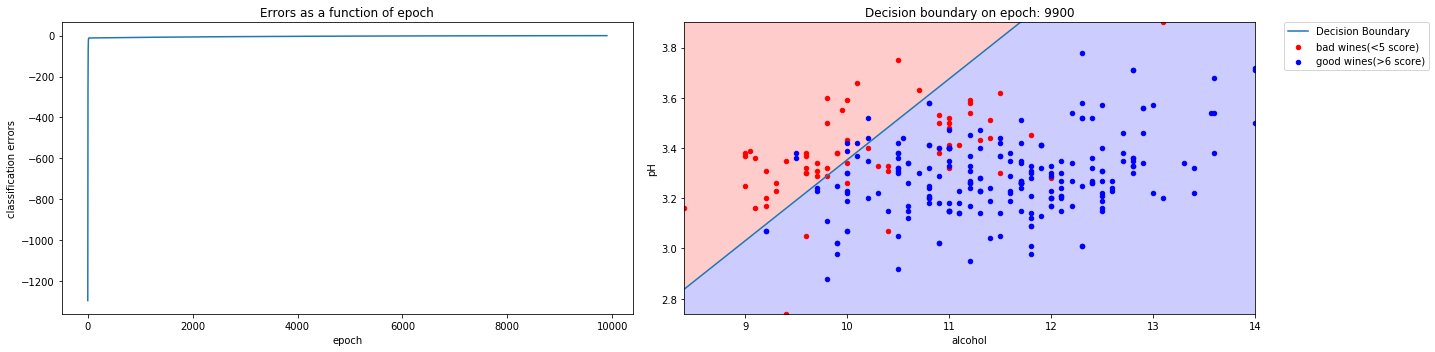

0.00022625537160224165


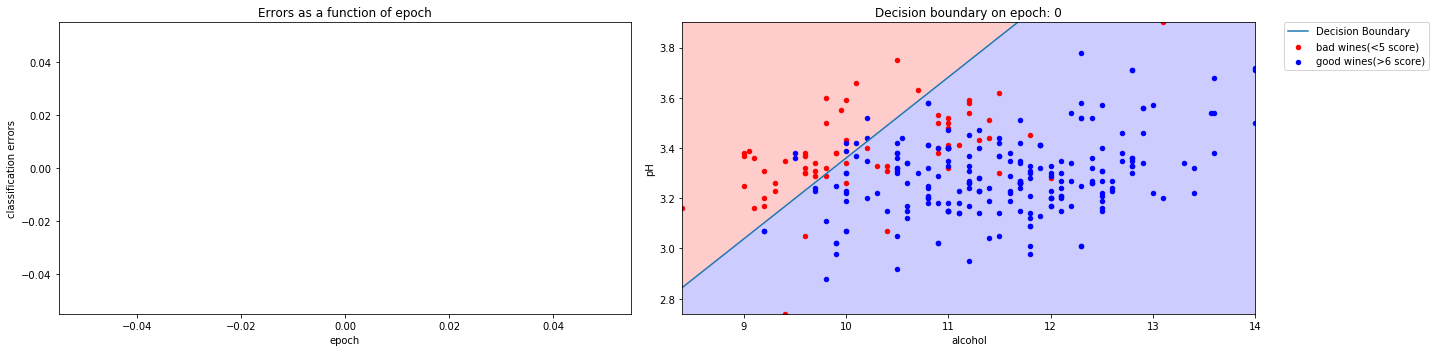

In [12]:
# tup = (i, sum(errors), self.w[1:], self.w[0], c)

def k_fold_training(eta_tmp = 0.0001, iteration=0):
    k_fold = 7
    df = pd.read_csv('winequality-red.csv', sep=';')
    df = df[(df.quality >= 7) | (df.quality <= 4)]
    data = k_fold_cross_validation(df, k=k_fold)
    ret = []
    validation_error = 0
    bias = 0
    weight = [0] * 2
    
    for i in range(k_fold):
        y = data[i][0]['quality'].values
        y = heaviside_step_function(y, 7)
        X = data[i][0][['pH', 'alcohol']].values
        ppn = Adaline(eta = eta_tmp, n_iter = iteration)
        val = ppn.fit(X, y)
        validation_error += val[-1:][0][1]
        plot_performance(val, df[['pH', 'alcohol', 'quality']], 7, 4, )
        bias += val[-1:][0][3]
        for j in range(len(val[-1:][0][2])):
            weight[j] += val[-1:][0][2][j]
    for j in range(len(weight)):
        weight[j] /= k_fold
    bias /= k_fold
    validation_error /= k_fold
    
    tup = [(0, 0, weight, bias)]
    
    print(validation_error)
    plot_performance(tup, df[['pH', 'alcohol', 'quality']], 7, 4, )
    
        
#    plot_cost([x[4] for x in ret], [x[0] for x in ret])
#    plot_performance(ret, df[['pH', 'alcohol', 'quality']], 8, 3, )

k_fold_training(eta_tmp = 0.00001, iteration=0)

# V.5 Adventures in the Nth dimension

a) Try training your perceptron/ADALINE with different numbers and types of chemical factors. Under what circumstances can perceptron/ADALINE successfully train?

Perceptron was easy to train in any circumstances, even with entire data. However, for Adaline, with 0.0001 learning rate, cost increased to infinite and with 0.00001 error was getting small but the cost was still pretty high. However, it was best to set Adaline's learning rate to 0.00001. 

In [13]:
def before():
    df = pd.read_csv('winequality-red.csv', sep=';')
    df = df[(df.quality >= 8) | (df.quality <= 3)]
    y = df['quality'].values
    y = heaviside_step_function(y, 8)
    X = df[["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]].values

    # made as class to make it easier to modify, eta: learning rate; n_iter: training epochs
    ppn1 = Perceptron(eta=0.1, n_iter = 0)
    ret = ppn1.fit(X, y)
    print(ret[len(ret) - 1])
    ppn2 = Adaline(eta = 0.0000001, n_iter = 0)
    ret2 = ppn2.fit(X, y)
    print(ret2[len(ret2) - 1])
    
before()

(260, 0, [-29.184120366376742, -136.66612036637653, 51.25587963362312, -15.804120366377138, -16.020520366376783, -1.0441203663768084, 0.9558796336229065, -24.461554366377005, -133.8741203663795, 25.219879633623183, 81.77587963362407], -24.24412036637688)


KeyboardInterrupt: 

b) What the decision boundary for 3 factors look like? What about 7 factors?

For 1 factor, it will be a point, for 2 factors, it will be a line, for 3 factors, it will be a plane, for n factiors, it is unknown, but that boundary should be exists in n-dimensional plane.

# V.6 Marvin's rebuttal

Use Pan-Galactic Gargle Blaster and solve it with single perceptron or ADALINE

a) While not a wine, find a way to successfully classify the Pan-Galactic Gargle Blaster dataset by plotting the decision boundary and also show 'good' and 'bad' Gargle Blaster data points.

In [18]:
plot_scatter_matrix("Pan Galactic Gargle Blaster.csv", 7, 3, save_plot=False)

<Figure size 432x288 with 0 Axes>

In [29]:
df = pd.read_csv("Pan Galactic Gargle Blaster.csv", sep=';')
data = df.copy()
minimum = [0] * 2
maximum = [0] * 2
means = [0] * 2
j = 0

for i in data.columns:
    if (i != 'quality'):
        minimum[j] = find_min_max(0, df[i].values)
        maximum[j] = find_min_max(1, df[i].values)
        means[j] = sum(df[i].values) / len(df[i].values)
        j += 1

k = 0

for i in data.columns:
    if (i != 'quality'):
        for j in range(len(data[i])):
            data[i].values[j] = (data[i][j] - means[k]) / (maximum[k] - minimum[k])
        k += 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


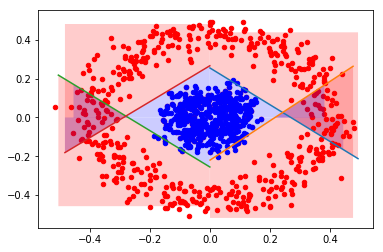

In [43]:
X_ = [0] * 4
y_ = [0] * 4

X_[0] = data[(data["wonderflonium"] >= 0) & (data["fallian marsh gas"] >= 0)]
X_[1] = data[(data["wonderflonium"] < 0) & (data["fallian marsh gas"] >= 0)]
X_[2] = data[(data["wonderflonium"] < 0) & (data["fallian marsh gas"] < 0)]
X_[3] = data[(data["wonderflonium"] >= 0) & (data["fallian marsh gas"] < 0)]

for i in range(4):
    y_[i] = X_[i]['quality'].values
    y_[i] = heaviside_step_function(y_[i], 7)
    ppn = Adaline(eta=0.0001, n_iter = 0)
    ret = ppn.fit(X_[i][["wonderflonium", "fallian marsh gas"]].values, y_[i])
    
    tup = ret[len(ret) - 1]
    y_min = find_min_max(0, X_[i]["wonderflonium"].values)
    y_max = find_min_max(1, X_[i]["wonderflonium"].values)    
    x_min = find_min_max(0, X_[i]["fallian marsh gas"].values)
    x_max = find_min_max(1, X_[i]["fallian marsh gas"].values)
    
    data0 = X_[i][(data['quality'] < 7)]
    data1 = X_[i][(data['quality'] >= 5)]
    
    y = [0] * 11
    x = [0] * 11
    
    slope = -(tup[3]/tup[2][0])/(tup[3]/tup[2][1])
    intercept = -tup[3]/tup[2][0]
    k = 0
    for i in range(11):
        x[i] = k + x_min
        y[i] = slope * x[i] + intercept
        k += (x_max - x_min) / 10
    plt.plot(x, y, label="Decision Boundary")
    f_color1 = ['blue' if y_min >= 0 else 'red']
    f_color2 = ['red' if y_min >= 0 else 'blue']
    plt.fill_between(x, y, y_min, where=y>y_min - 0.2, facecolor=f_color1, alpha=.2)
    plt.fill_between(x, y, y_max, where=y<y_max + 0.2, facecolor=f_color2, alpha=.2)
    plt.scatter(data0["wonderflonium"], data0["fallian marsh gas"], c='red', s=20)
    plt.scatter(data1["wonderflonium"], data1["fallian marsh gas"], c='blue', s=20)    